In [1]:
!pip install pandas scikit-learn matplotlib seaborn openpyxl xlsxwriter WordCloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.3 MB/s eta 0:00:00


=== Analisis TF-IDF untuk Data Stemming ===
Input file: Data Pakar Stemming.xlsx
Text column: stem_clean
--------------------------------------------------
1. Memuat data...
Data berhasil dimuat. Jumlah baris: 500
Kolom yang tersedia: ['nama', 'komen', 'sentimen pakar', 'tokenized', 'stopword_clean', 'stem_clean']
Jumlah baris setelah menghapus nilai kosong: 500
2. Mempersiapkan dokumen...
3. Menghitung TF-IDF...
TF-IDF Matrix shape: (500, 1000)
Jumlah fitur (kata unik): 1000
4. Menganalisis kata-kata teratas...

Top 20 kata dengan skor TF-IDF tertinggi:
         word  tfidf_score
452      kuil     0.063481
322     indah     0.058963
67       bali     0.053516
725      pura     0.051603
877     tanah     0.049738
664   pandang     0.049012
536       lot     0.048580
592  matahari     0.047466
89      benam     0.046268
338     jalan     0.044277
62      bagus     0.042785
456   kunjung     0.042424
13        air     0.039501
489      laut     0.036857
961    unjung     0.035069
688    

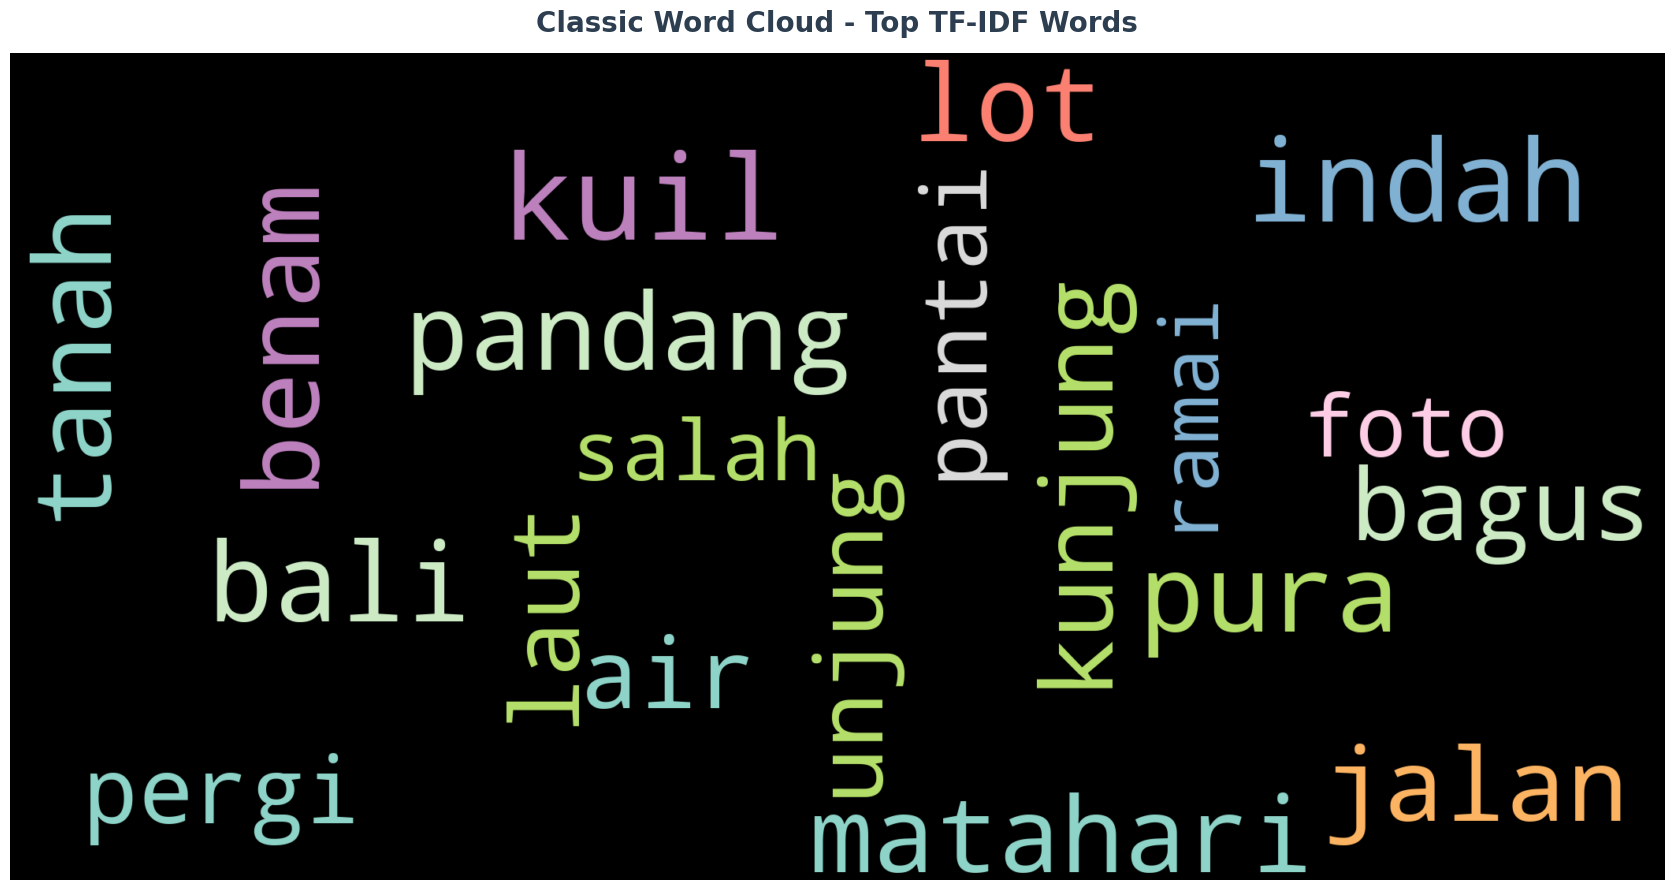

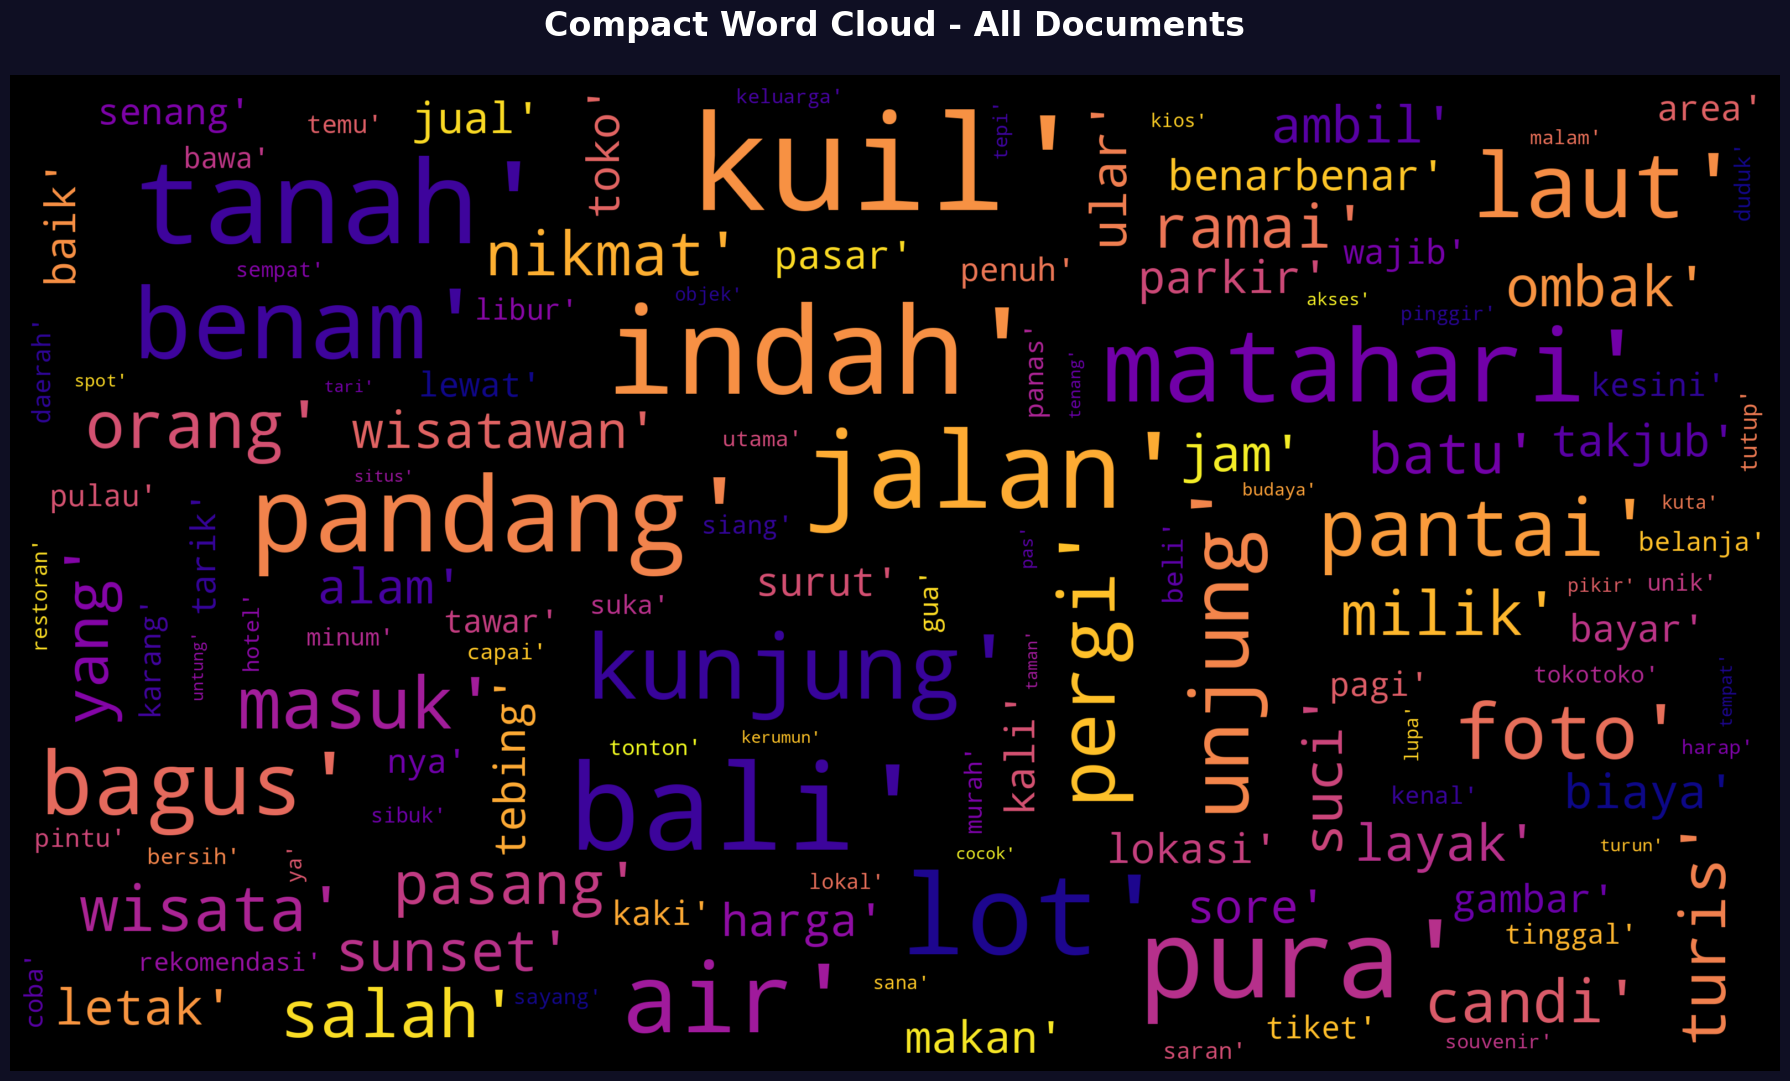

Word cloud berhasil disimpan ke wordcloud_tfidf_dense.png
8. Menyimpan hasil...
Hasil berhasil disimpan ke tfidf_results.xlsx

=== Statistik Tambahan ===
Total dokumen: 500
Total kata unik: 1000
Rata-rata panjang dokumen: 24.14 kata
Dokumen terpendek: 5 kata
Dokumen terpanjang: 121 kata

=== Analisis Selesai ===


In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

def load_stemmed_data(file_path, text_column='stemmed_text'):
    """
    Memuat data dari file Excel yang berisi hasil stemming

    Args:
        file_path (str): Path ke file Excel
        text_column (str): Nama kolom yang berisi teks hasil stemming

    Returns:
        pandas.DataFrame: Data yang telah dimuat
    """
    try:
        # Membaca file Excel
        df = pd.read_excel(file_path)
        print(f"Data berhasil dimuat. Jumlah baris: {len(df)}")
        print(f"Kolom yang tersedia: {list(df.columns)}")

        # Periksa apakah kolom teks ada
        if text_column not in df.columns:
            print(f"Kolom '{text_column}' tidak ditemukan. Kolom yang tersedia: {list(df.columns)}")
            return None

        # Hapus baris dengan nilai kosong
        df = df.dropna(subset=[text_column])
        print(f"Jumlah baris setelah menghapus nilai kosong: {len(df)}")

        return df

    except Exception as e:
        print(f"Error saat memuat data: {str(e)}")
        return None

def calculate_tfidf(documents, max_features=1000, min_df=1, max_df=0.8):
    """
    Menghitung TF-IDF dari dokumen-dokumen

    Args:
        documents (list): List berisi teks dokumen
        max_features (int): Jumlah maksimal fitur (kata)
        min_df (int/float): Frekuensi minimum dokumen
        max_df (float): Frekuensi maksimum dokumen

    Returns:
        tuple: (tfidf_matrix, feature_names, vectorizer)
    """
    # Inisialisasi TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        stop_words=None,  # Asumsi stop words sudah dihapus saat preprocessing
        lowercase=True,
        token_pattern=r'\b[a-zA-Z]+\b'  # Hanya kata-kata alphabetic
    )

    # Hitung TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(documents)

    # Ambil nama fitur (kata-kata)
    feature_names = vectorizer.get_feature_names_out()

    print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
    print(f"Jumlah fitur (kata unik): {len(feature_names)}")

    return tfidf_matrix, feature_names, vectorizer

def get_top_tfidf_words(tfidf_matrix, feature_names, top_n=10):
    """
    Mendapatkan kata-kata dengan skor TF-IDF tertinggi

    Args:
        tfidf_matrix: Matrix TF-IDF
        feature_names: Nama fitur/kata
        top_n (int): Jumlah kata teratas yang ingin ditampilkan

    Returns:
        pandas.DataFrame: DataFrame berisi kata dan skor TF-IDF rata-rata
    """
    # Hitung rata-rata TF-IDF untuk setiap kata
    mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()

    # Buat DataFrame
    tfidf_df = pd.DataFrame({
        'word': feature_names,
        'tfidf_score': mean_scores
    })

    # Sort berdasarkan skor TF-IDF
    tfidf_df = tfidf_df.sort_values('tfidf_score', ascending=False)

    return tfidf_df.head(top_n)

def create_tfidf_dataframe(tfidf_matrix, feature_names, document_ids=None):
    """
    Membuat DataFrame dari matrix TF-IDF

    Args:
        tfidf_matrix: Matrix TF-IDF
        feature_names: Nama fitur/kata
        document_ids: ID dokumen (optional)

    Returns:
        pandas.DataFrame: DataFrame TF-IDF
    """
    # Konversi ke dense array
    tfidf_dense = tfidf_matrix.todense()

    # Buat DataFrame
    tfidf_df = pd.DataFrame(tfidf_dense, columns=feature_names)

    # Tambahkan ID dokumen jika tersedia
    if document_ids is not None:
        tfidf_df.insert(0, 'document_id', document_ids)

    return tfidf_df

def calculate_document_similarity(tfidf_matrix):
    """
    Menghitung similarity antar dokumen menggunakan cosine similarity

    Args:
        tfidf_matrix: Matrix TF-IDF

    Returns:
        numpy.ndarray: Matrix similarity
    """
    # Hitung cosine similarity
    similarity_matrix = cosine_similarity(tfidf_matrix)

    return similarity_matrix

def create_wordcloud(top_words_df, max_words=100, title="Word Cloud - TF-IDF Scores"):
    """
    Membuat word cloud dari kata-kata dengan skor TF-IDF

    Args:
        top_words_df: DataFrame berisi kata dan skor TF-IDF
        max_words (int): Jumlah maksimal kata yang ditampilkan
        title (str): Judul word cloud
    """
    # Buat dictionary dari kata dan skor TF-IDF
    word_freq = dict(zip(top_words_df['word'], top_words_df['tfidf_score']))

    # Konfigurasi WordCloud yang lebih baik
    wordcloud = WordCloud(
        width=1600,
        height=900,
        background_color='black',
        max_words=max_words,
        colormap='Set1',  # Warna-warna cerah dan kontras
        relative_scaling=0.6,
        random_state=42,
        font_path=None,
        max_font_size=120,
        min_font_size=15,
        prefer_horizontal=0.9,
        scale=2,
        margin=20,
        collocations=False
    ).generate_from_frequencies(word_freq)

    # Tampilkan word cloud dengan styling yang lebih baik
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

    # Styling judul
    fig.suptitle(title, fontsize=24, fontweight='bold', color='white', y=0.95)
    fig.patch.set_facecolor('#1a1a1a')  # Dark background untuk figure

    plt.tight_layout()
    plt.show()

def create_combined_wordcloud(documents, title="Word Cloud - All Documents"):
    """
    Membuat word cloud dari semua dokumen yang digabungkan

    Args:
        documents: List dokumen teks
        title (str): Judul word cloud
    """
    # Gabungkan semua dokumen
    all_text = ' '.join(documents)

    # Konfigurasi WordCloud dengan styling yang lebih baik
    wordcloud = WordCloud(
        width=1600,
        height=900,
        background_color='black',
        max_words=150,
        colormap='plasma',
        relative_scaling=0.6,
        random_state=42,
        font_path=None,
        max_font_size=120,
        min_font_size=15,
        prefer_horizontal=0.8,
        scale=2,
        margin=20,
        collocations=False
    ).generate(all_text)

    # Tampilkan word cloud dengan styling yang lebih baik
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

    # Styling judul
    fig.suptitle(title, fontsize=24, fontweight='bold', color='white', y=0.95)
    fig.patch.set_facecolor('#0f0f23')  # Dark background untuk figure

    plt.tight_layout()
    plt.show()

def save_wordcloud(top_words_df, filename='wordcloud_tfidf_dense.png', max_words=120):
    """
    Menyimpan word cloud ke file gambar dengan style yang rapat

    Args:
        top_words_df: DataFrame berisi kata dan skor TF-IDF
        filename (str): Nama file output
        max_words (int): Jumlah maksimal kata
    """
    try:
        # Buat dictionary dari kata dan skor TF-IDF
        word_freq = dict(zip(top_words_df['word'], top_words_df['tfidf_score']))

        # Konfigurasi WordCloud untuk save dengan style rapat
        wordcloud = WordCloud(
            width=1400,
            height=700,
            background_color='black',
            max_words=max_words,
            colormap='Set3',
            relative_scaling=0.4,
            random_state=42,
            font_path=None,
            max_font_size=100,
            min_font_size=10,
            prefer_horizontal=0.65,
            scale=1.5,
            margin=8,
            collocations=False,
            include_numbers=False
        ).generate_from_frequencies(word_freq)

        # Simpan ke file
        wordcloud.to_file(filename)
        print(f"Word cloud berhasil disimpan ke {filename}")

    except Exception as e:
        print(f"Error saat menyimpan word cloud: {str(e)}")

def create_classic_wordcloud(top_words_df, max_words=120, title="Classic Word Cloud"):
    """
    Membuat word cloud dengan style klasik yang rapat
    """
    # Buat dictionary dari kata dan skor TF-IDF
    word_freq = dict(zip(top_words_df['word'], top_words_df['tfidf_score']))

    # Konfigurasi WordCloud dengan gaya klasik
    wordcloud = WordCloud(
        width=1400,
        height=700,
        background_color='black',
        max_words=max_words,
        colormap='Set3',  # Warna yang lebih soft dan natural
        relative_scaling=0.4,
        random_state=123,
        font_path=None,
        max_font_size=100,
        min_font_size=10,
        prefer_horizontal=0.65,
        scale=1.5,
        margin=8,
        collocations=False,
        include_numbers=False,
        normalize_plurals=False
    ).generate_from_frequencies(word_freq)

    # Tampilkan dengan styling yang bersih
    fig, ax = plt.subplots(figsize=(18, 9))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

    # Judul dengan styling yang lebih sederhana
    plt.title(title, fontsize=20, fontweight='bold', pad=15, color='#2c3e50')
    plt.tight_layout()
    plt.show()

def save_results(tfidf_df, top_words_df, output_file='tfidf_results.xlsx'):
    """
    Menyimpan hasil TF-IDF ke file Excel

    Args:
        tfidf_df: DataFrame TF-IDF lengkap
        top_words_df: DataFrame kata-kata teratas
        output_file (str): Nama file output
    """
    try:
        with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
            # Sheet untuk TF-IDF matrix
            tfidf_df.to_excel(writer, sheet_name='TF-IDF Matrix', index=False)

            # Sheet untuk kata-kata teratas
            top_words_df.to_excel(writer, sheet_name='Top Words', index=False)

        print(f"Hasil berhasil disimpan ke {output_file}")

    except Exception as e:
        print(f"Error saat menyimpan file: {str(e)}")

def main():
    """
    Fungsi utama untuk menjalankan analisis TF-IDF
    """
    # Konfigurasi
    INPUT_FILE = 'Data Pakar Stemming.xlsx'  # Ganti dengan path file Anda
    TEXT_COLUMN = 'stem_clean'       # Ganti dengan nama kolom teks
    OUTPUT_FILE = 'tfidf_results.xlsx'

    print("=== Analisis TF-IDF untuk Data Stemming ===")
    print(f"Input file: {INPUT_FILE}")
    print(f"Text column: {TEXT_COLUMN}")
    print("-" * 50)

    # 1. Load data
    print("1. Memuat data...")
    df = load_stemmed_data(INPUT_FILE, TEXT_COLUMN)

    if df is None:
        print("Gagal memuat data. Program dihentikan.")
        return

    # 2. Persiapkan dokumen
    print("2. Mempersiapkan dokumen...")
    documents = df[TEXT_COLUMN].tolist()
    document_ids = df.index.tolist()

    # 3. Hitung TF-IDF
    print("3. Menghitung TF-IDF...")
    tfidf_matrix, feature_names, vectorizer = calculate_tfidf(
        documents,
        max_features=1000,
        min_df=1,
        max_df=0.8
    )

    # 4. Dapatkan kata-kata teratas
    print("4. Menganalisis kata-kata teratas...")
    top_words = get_top_tfidf_words(tfidf_matrix, feature_names, top_n=20)
    print("\nTop 20 kata dengan skor TF-IDF tertinggi:")
    print(top_words)

    # 5. Buat DataFrame TF-IDF
    print("5. Membuat DataFrame TF-IDF...")
    tfidf_df = create_tfidf_dataframe(tfidf_matrix, feature_names, document_ids)

    # 6. Hitung similarity antar dokumen
    print("6. Menghitung similarity antar dokumen...")
    similarity_matrix = calculate_document_similarity(tfidf_matrix)
    print(f"Similarity matrix shape: {similarity_matrix.shape}")

    # 7. Visualisasi Word Cloud
    print("7. Membuat visualisasi word cloud...")

    # Word cloud klasik yang rapat
    create_classic_wordcloud(top_words, max_words=100, title="Classic Word Cloud - Top TF-IDF Words")

    # Word cloud compact dari semua dokumen
    create_combined_wordcloud(documents, title="Compact Word Cloud - All Documents")

    # Simpan word cloud ke file
    save_wordcloud(top_words, 'wordcloud_tfidf_dense.png', max_words=100)

    # 8. Simpan hasil
    print("8. Menyimpan hasil...")
    save_results(tfidf_df, top_words, OUTPUT_FILE)

    # 9. Statistik tambahan
    print("\n=== Statistik Tambahan ===")
    print(f"Total dokumen: {len(documents)}")
    print(f"Total kata unik: {len(feature_names)}")
    print(f"Rata-rata panjang dokumen: {np.mean([len(doc.split()) for doc in documents]):.2f} kata")
    print(f"Dokumen terpendek: {min([len(doc.split()) for doc in documents])} kata")
    print(f"Dokumen terpanjang: {max([len(doc.split()) for doc in documents])} kata")

    print("\n=== Analisis Selesai ===")

if __name__ == "__main__":
    # Pastikan library wordcloud terinstall
    try:
        from wordcloud import WordCloud
        main()
    except ImportError:
        print("Error: Library 'wordcloud' tidak ditemukan!")
        print("Silakan install dengan: pip install wordcloud")
        print("Atau jika menggunakan conda: conda install -c conda-forge wordcloud")